In [10]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df =pd.read_csv('train.csv')

### UNCOMMENT THIS PART TO USE THE FEATURE ENGINEERING

df['total_call'] = df['total_day_calls'] + df['total_eve_calls'] + df['total_night_calls']

# Create 'total_charges' feature
df['total_charges'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge']

# Create 'total_minutes' feature
df['total_minutes'] = df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes']
df = df.drop(['total_day_calls', 'total_eve_calls', 'total_night_calls'], axis=1)

# Delete contributing features for 'total_charges'
df = df.drop(['total_day_charge', 'total_eve_charge', 'total_night_charge'], axis=1)

# Delete contributing features for 'total_minutes'
df = df.drop(['total_day_minutes', 'total_eve_minutes', 'total_night_minutes'], axis=1)


df.drop(['state'], axis=1, inplace=True)
# df.drop(['state', 'area_code', 'account_length'], axis=1, inplace=True)



###################

###ONE HOT ENCODING


df = pd.get_dummies(df, columns=['area_code'])


### MOVING THE Y VARIABLE TO THE END AFTER ONE HOT ENCODING
churn = df['churn']
df = df.drop('churn', axis=1)
df['churn'] = churn

### CONVERT BINARY COLUMNS TO 0 AND 1

data=np.array(df)
data[data=='no']=0
data[data=='yes']=1
data[data==False]=0
data[data==True]=1


### SPLITTING THE DATA INTO X AND Y
X=data[:,:-1]
y=data[:,-1]



### SPLITTING THE DATA INTO TRAIN, VALIDATION AND TEST SETS
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) 
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) 


###DATA NORMALIZATION
def normalize(X):
    X = X.astype(float)
    X=(X-X.mean(axis=0))/X.std(axis=0)
    return X

X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)


#SMOTE, oversampling the minority class (will read more about this later)
# X_train_oversampled_smote = []
# labels_train_oversampled_smote = []
# indices_0 = np.where(y_train == 0)[0]
# indices_1 = np.where(y_train == 1)[0]
# indices = np.concatenate([indices_0, indices_1])
# for _ in range(X_train.shape[0]):
#     p = np.random.random()
#     #sample from majority class
#     if p < 0.5:
#         X_train_oversampled_smote.append(X_train[np.random.choice(indices_0)])
#         labels_train_oversampled_smote.append(0)
#     #sample from minority class
#     else:
#         #get two random samples from minority class
#         minority_samp_1 = X_train[np.random.choice(indices_1)]
#         minority_samp_2 = X_train[np.random.choice(indices_1)]
        
#         #get random proportion with which to mix them
#         prop = np.random.random()
        
#         #generate synthetic sample from minority class
#         synthetic_minority_samp = prop*minority_samp_1 + (1-prop)*minority_samp_2
#         X_train_oversampled_smote.append(synthetic_minority_samp)
#         labels_train_oversampled_smote.append(1)
        
# X_train_with_SMOTE = np.array(X_train_oversampled_smote)
# y_train_with_SMOTE = np.array(labels_train_oversampled_smote)

# X_train_with_SMOTE = X_train_with_SMOTE.astype(np.float32)
# y_train_with_SMOTE = y_train_with_SMOTE.astype(np.float32)
# y_train_with_SMOTE = y_train_with_SMOTE.reshape(-1,1)



###CONVERT TO APPROPIATE FORMAT

X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)

y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
y_test = y_test.reshape(-1,1)
####



In [11]:
### FUNCTION DEFINITIONS

def reLU(z):
    return np.maximum(0,z)

def reLU_derivative(z):
    return z>0

def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoid_derivative(z):
    return sigmoid(z)*(1-sigmoid(z))


#### -0.5 is for preventing the weights from being too large, causing overflow of sigmoid
def initialize_parameters(model):
    W=[]
    b=[]
    for i in range(1,len(model)):
        W.append(np.random.rand(model[i-1],model[i]) - 0.5)
        b.append(np.random.rand(1,model[i]) - 0.5)
    return W,b



def my_dense(X,W,b, use_sigmoid=False):
    z=np.matmul(X,W)+b 
    return sigmoid(z) if use_sigmoid else reLU(z)


def forward_propagation(X,W,b):
    A=[]
    prev_A=X
    for i in range(len(W)):
        prev_A=my_dense(prev_A,W[i],b[i], use_sigmoid=(i==len(W)-1))
        A.append(prev_A)
    return A     
    
    

def squared_error(y,A):
    return np.sum((y-A)**2)/y.shape[0]


def update_parameters(W,b,dW,db,learning_rate):
    for i in range(len(W)):
        W[i]=W[i]-learning_rate*dW[i]
        b[i]=b[i]-learning_rate*db[i]
    return W,b

def back_propagation(X,y,A,W,alpha=0.01):
    dW=[]
    db=[]
    m=y.shape[0]
    
    #### CALCULATING dC/dA
    dA=(A[-1]-y)
    #### CALCULATING dC/dZ by using the chain rules
    dZ=dA*sigmoid_derivative(A[-1])
    
    #### CALCULATING dC/dW and alpha * W is the regularization term
    dC_dW = (A[-2].T.dot(dZ)+alpha * W[-1])/m
    dW.append(dC_dW)
    
    #### CALCULATING dC/db
    
    dC_db=np.sum(dZ,axis=0,keepdims=True)/m
    db.append(dC_db)
  
  
    for i in range(len(W)-2,0,-1):
       
        dC_dA=dZ.dot(W[i+1].T)
        dA_dZ=reLU_derivative(A[i])
        dZ=dC_dA*dA_dZ
        dW.append((A[i-1].T.dot(dZ)+alpha * W[i])/m)
        db.append(np.sum(dZ,axis=0,keepdims=True)/m)
        
    ### split to dot product with X
    dZ=dZ.dot(W[1].T)*reLU_derivative(A[0])
    dW.append((X.T.dot(dZ)+alpha * W[0])/m)
    db.append(np.sum(dZ,axis=0,keepdims=True)/m)
    
    ### return the inverse of dW and db because we calculated them in reverse order
    return dW[::-1],db[::-1]


def train(X_train,y_train,X_valid,y_valid,learning_rate,epochs,alpha,model):
    costs_train=[]
    costs_valid=[]
    W,b=initialize_parameters(model)
    for i in range(epochs):
        A=forward_propagation(X_train,W,b)
        dW,db=back_propagation(X_train,y_train,A,W,alpha)
        W,b=update_parameters(W,b,dW,db,learning_rate)
        loss=squared_error(y_train,A[-1])
        
        loss_valid=squared_error(y_valid,forward_propagation(X_valid,W,b)[-1])
        costs_train.append(loss)
        
        costs_valid.append(loss_valid)
        acc=accuracy(y_train,A[-1])
        print(f"Epoch {i} : Loss {loss}")
        print(f"Train Accuracy: {acc}")
        acc_valid=accuracy(y_valid,forward_propagation(X_valid,W,b)[-1])
        print(f"Validation Loss: {loss_valid}")
        print(f"Validation Accuracy: {acc_valid}")
        
        if acc == 1:
            break
        
        
        
    return W,b,costs_train,costs_valid



def accuracy(y,A,threshold=0.5):
    return np.mean((A>threshold)==y)
X_train.shape

(2975, 14)

In [12]:
model_list=[[X_train.shape[1],64,128,64,64,1]]
lr_list = [0.1]
alpha_list = [0.01]
threshold_list = [0.5]
default_epoch = 10000
best_accuracy = 0
best_model=[]
layer_cost_train = []
layer_cost_valid=[]
# avg_accuracy_without_SMOTE = 0
# avg_f1_without_SMOTE = 0
# avg_accuracy_with_SMOTE = 0
# avg_f1_with_SMOTE = 0

from sklearn.metrics import f1_score
for i in range(1):
    for model in model_list:
        for lr in lr_list:
            for alpha in alpha_list:
                for threshold in threshold_list:
                    W,b,costs_train,costs_valid=train(X_train,y_train,X_val,y_val,lr,default_epoch,alpha,model)
                    layer_cost_train.append(costs_train)
                    layer_cost_valid.append(costs_valid)
                    A=forward_propagation(X_val,W,b)
                    acc = accuracy(y_val,A[-1],threshold)
                    print(f"Validation Accuracy: {acc}")
                    # avg_accuracy_without_SMOTE += acc
                    # avg_f1_without_SMOTE += f1_score(y_val, A[-1]>threshold)
                    acc_test = accuracy(y_test,forward_propagation(X_test,W,b)[-1],threshold)
                    print(f"Test Accuracy: {acc_test}")
                    
                    if acc > best_accuracy:
                        best_accuracy = acc
                        best_lr = lr
                        best_alpha = alpha
                        best_threshold = threshold
                        W_best = W
                        b_best = b
                        best_model=model
                        

# avg_accuracy_without_SMOTE /= 10     
# avg_f1_without_SMOTE /= 10         

# for i in range(1):
#     for layers in layer_list:
#         for lr in lr_list:
#             for reg in reg_list:
#                 for threshold in threshold_list:
#                     W,b,costs_train,costs_valid=train(X_train_oversampled,y_train_oversampled,X_val,y_val,lr,default_epoch,layers)
#                     layer_cost_train.append((layers,costs_train))
#                     layer_cost_valid.append((layers,costs_valid))
#                     A=forward_propagation(X_val,W,b)
#                     acc = accuracy(y_val,A[-1],threshold)
#                     print(f"Validation Accuracy: {acc}")
#                     avg_accuracy_with_SMOTE += acc
#                     avg_f1_with_SMOTE += f1_score(y_val, A[-1]>threshold)
#                     acc_test = accuracy(y_test,forward_propagation(X_test,W,b)[-1],threshold)
#                     print(f"Test Accuracy: {acc_test}")
                    
#                     if acc > best_accuracy:
#                         best_accuracy = acc
#                         best_lr = lr
#                         best_reg = reg
#                         best_threshold = threshold
#                         W_best = W
#                         b_best = b
#                         best_layer = layers
                        
                        
# avg_accuracy_with_SMOTE /= 10
# avg_f1_with_SMOTE /= 10

A_test=forward_propagation(X_test,W_best,b_best)
acc_test = accuracy(y_test,A_test[-1],best_threshold)
print(f"Best Accuracy on validation set: {best_accuracy}")    
print(f"Best Learning Rate: {best_lr}")
print(f"Best Regularization: {best_alpha}")
print(f"Best Threshold: {best_threshold}")
print(f"Best Layer: {best_model}")
print(f"Test Accuracy with W,b: {acc_test}")


import pickle

# Save W and b to a single file
with open('parameters.pkl', 'wb') as f:
    pickle.dump((W_best,b_best ), f)

Epoch 0 : Loss 0.7940458770466167
Train Accuracy: 0.16806722689075632
Validation Loss: 0.1416267648099138
Validation Accuracy: 0.858712715855573
Epoch 1 : Loss 0.13548346550616464
Train Accuracy: 0.8645378151260504
Validation Loss: 0.13938544547330006
Validation Accuracy: 0.8540031397174255
Epoch 2 : Loss 0.13914787192977543
Train Accuracy: 0.8554621848739495
Validation Loss: 0.1577079202468373
Validation Accuracy: 0.8210361067503925
Epoch 3 : Loss 0.1604636053797254
Train Accuracy: 0.8134453781512605
Validation Loss: 0.1809492650718849
Validation Accuracy: 0.7770800627943485
Epoch 4 : Loss 0.18046145658599505
Train Accuracy: 0.7761344537815126
Validation Loss: 0.16638698394133966
Validation Accuracy: 0.792778649921507
Epoch 5 : Loss 0.1645893871748365
Train Accuracy: 0.7973109243697479
Validation Loss: 0.16276718327677475
Validation Accuracy: 0.8021978021978022
Epoch 6 : Loss 0.15962582471395567
Train Accuracy: 0.7979831932773109
Validation Loss: 0.15515144028540587
Validation Accurac

In [13]:
# print(f"Avg accuracy with SMOTE: {avg_accuracy_with_SMOTE}")
# print(f"F1 score with SMOTE: {avg_f1_with_SMOTE}")
# print(f"Avg accuracy without SMOTE: {avg_accuracy_without_SMOTE}")
# print(f"F1 score without SMOTE: {avg_f1_without_SMOTE}")

In [14]:
# import matplotlib.pyplot as plt

# # Plot the first average F1 score
# plt.subplot(1, 2, 1)
# plt.bar(['With SMOTE', 'Without SMOTE'], [avg_f1_with_SMOTE, avg_f1_without_SMOTE])
# plt.title('Average F1 Score')

# # Plot the second average accuracy
# plt.subplot(1, 2, 2)
# plt.bar(['With SMOTE', 'Without SMOTE'], [avg_accuracy_with_SMOTE, avg_accuracy_without_SMOTE])
# plt.title('Average Accuracy')

# # Show the plot
# plt.show()


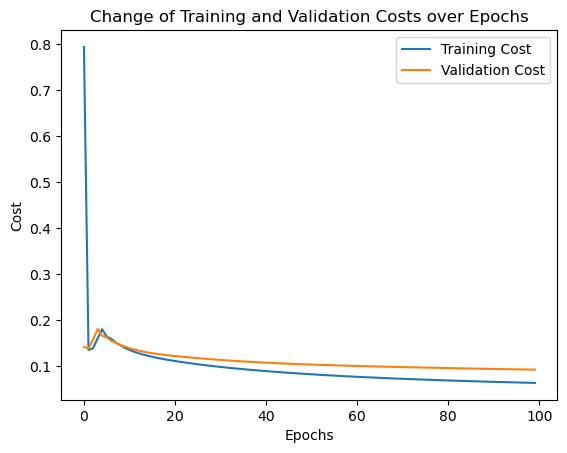

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Define the lists of training and validation costs
train_costs = layer_cost_train
val_costs = layer_cost_valid

# Reshape the arrays to have the same first dimension
train_costs = np.reshape(train_costs, (-1,))
val_costs = np.reshape(val_costs, (-1,))

# Create the x-axis values (epochs) in the interval of 5000
epoch_range=100
epochs = range(epoch_range)

# Plot the training and validation costs
plt.plot(epochs, train_costs[:epoch_range], label='Training Cost')
plt.plot(epochs, val_costs[:epoch_range], label='Validation Cost')

# Add labels and title to the plot
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Change of Training and Validation Costs over Epochs')

# Add legend
plt.legend()

# Show the plot
plt.show()

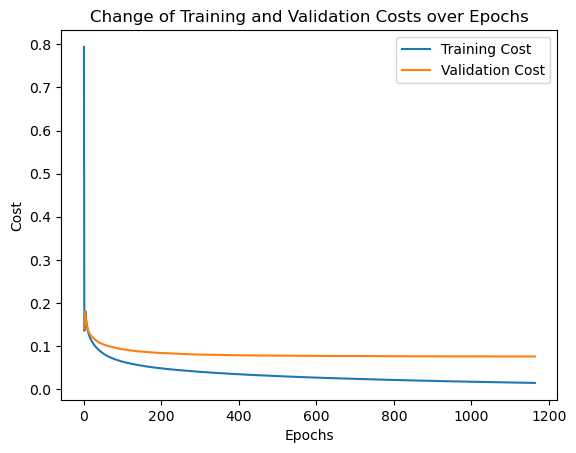

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Define the lists of training and validation costs
train_costs = layer_cost_train
val_costs = layer_cost_valid

# Reshape the arrays to have the same first dimension
train_costs = np.reshape(train_costs, (-1,))
val_costs = np.reshape(val_costs, (-1,))

# Create the x-axis values (epochs) in the interval of 5000
epochs = range(1165)

# Plot the training and validation costs
plt.plot(epochs, train_costs[:1165], label='Training Cost')
plt.plot(epochs, val_costs[:1165], label='Validation Cost')

# Add labels and title to the plot
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Change of Training and Validation Costs over Epochs')

# Add legend
plt.legend()

# Show the plot
plt.show()

Threshold: 0.5
F1 score for y_test with W,b: 0.7243243243243243

Threshold: 0.6
F1 score for y_test with W,b: 0.7222222222222222

Threshold: 0.7
F1 score for y_test with W,b: 0.7085714285714285

Threshold: 0.8
F1 score for y_test with W,b: 0.6900584795321637

Threshold: 0.9
F1 score for y_test with W,b: 0.6503067484662578



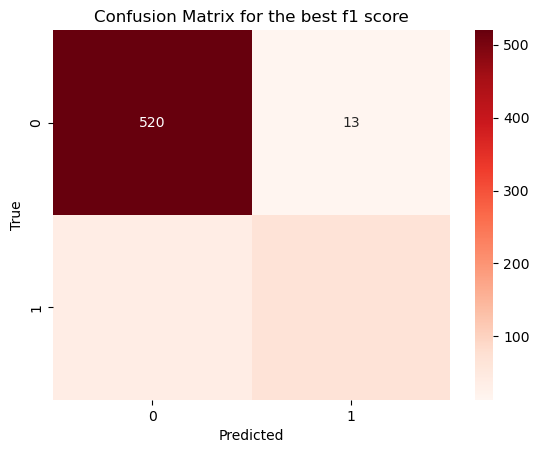

[[520  13]
 [ 38  67]]
Best threshold: 0.5


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

def predict(X,W,b,threshold):
    return forward_propagation(X,W,b)[-1]>threshold
best_threshold = -1
best_f1=-1
threshold_list = [0.5, 0.6, 0.7, 0.8, 0.9]
for threshold in threshold_list:
    y_pred = predict(X_test, W_best, b_best, threshold)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Threshold: {threshold}")

    print(f"F1 score for y_test with W,b: {f1_score(y_test, y_pred)}")
    if f1_score(y_test, y_pred) > best_f1:
        best_f1 = f1_score(y_test, y_pred)
        best_threshold = threshold
        best_y_pred = y_pred
        best_cm = cm
    print()
# Assuming y_test is the true labels and y_pred is the predicted labels
# Calculate the confusion matrix


# Plot the confusion matrix using seaborn
sns.heatmap(best_cm, annot=True, cmap='Reds', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for the best f1 score')
plt.show()
print(best_cm)
print(f"Best threshold: {best_threshold}")
